In [10]:
import pandas as pd
how_big_run="full" # "quick" "small" "medium" "large" "full" # data will be updated. Let's use "full" when it is ready

def load_data(what:str,how_big_run=how_big_run):
    return pd.read_feather(f'./bgg_data/bgg_{what}_{how_big_run}.feather')

ratings = load_data("ratings")
ratings=ratings[["bgg_id","game_name", "rating"]]
games=load_data("games")
games.rename(columns={'name': 'game_name'}, inplace=True)
games=games[["bgg_id","game_name"]]

ratings['rating']=ratings['rating'].round().astype(int)
ratings

,bgg_id,game_name,rating
0,267127,Aerion,7
1,247367,"Air, Land, & Sea",7
2,234487,Altiplano,7
3,140934,Arboretum,7
4,257499,Arkham Horror (Third Edition),8
...,...,...,...
198162,148228,Splendor,7
198163,1917,Stratego,5
198164,182351,Thief's Market,7
198165,179172,Unfair,9


In [11]:
ratings_wide = pd.crosstab(ratings['bgg_id'], ratings['rating']).reset_index()
ratings_wide.columns.name = None
ratings_wide = ratings_wide.merge(games, on='bgg_id')
ratings_wide

ratings_wide['nro_reviews'] = ratings_wide[[i for i in range(1, 11)]].sum(axis=1)
ratings_wide


,bgg_id,1,2,3,4,5,6,7,8,9,10,game_name,nro_reviews
0,1,0,0,0,0,2,8,9,27,14,12,Die Macher,72
1,2,0,0,0,1,1,2,1,0,0,0,Dragonmaster,5
2,3,0,0,1,1,7,12,33,43,15,6,Samurai,118
3,4,0,0,0,0,0,1,1,2,0,0,Tal der Könige,4
4,5,0,0,1,0,15,24,61,38,16,10,Acquire,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21760,451576,0,0,0,1,0,0,0,0,0,0,Эрнесто Капибара (Ernesto Capybara),1
21761,451681,0,0,0,1,0,0,0,0,0,0,У Кого Больше (Who Has More?),1
21762,451790,0,0,0,0,0,0,1,0,0,0,Nap & Roll,1
21763,452479,0,0,0,0,0,0,0,1,0,0,Train of Thought: a game of exciting questions...,1


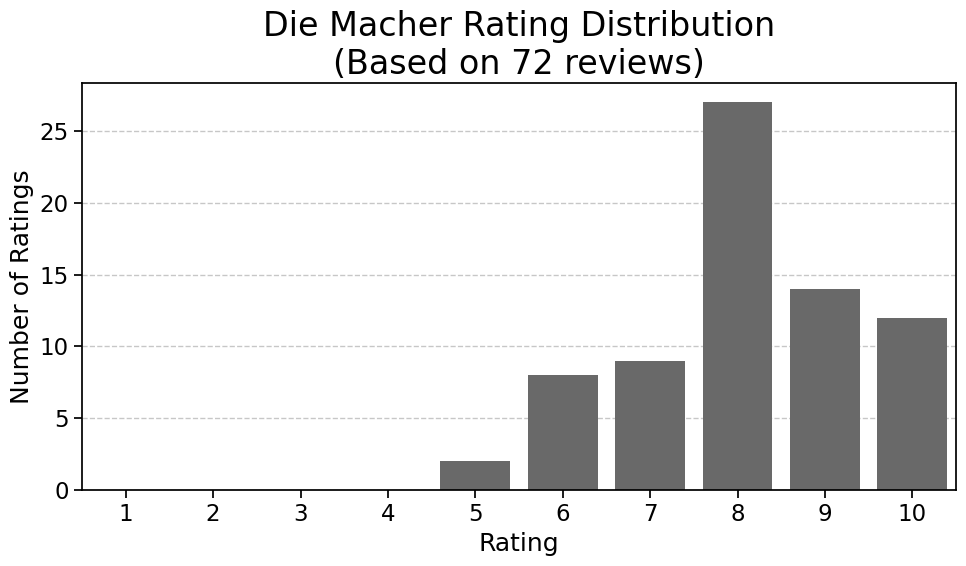

(<Figure size 640x480 with 0 Axes>,
 <Axes: title={'center': 'Die Macher Rating Distribution\n(Based on 72 reviews)'}, xlabel='Rating', ylabel='Number of Ratings'>)

<Figure size 640x480 with 0 Axes>

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)

def plot_game_ratings(df, game_name=None, bgg_id=None, save_path=None):
    """
    Creates a bar plot showing the distribution of ratings for a specific board game.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing game ratings data
    game_name : str, optional
        Name of the game to plot
    bgg_id : int, optional
        ID of the game to plot (alternative to game_name)
    save_path : str, optional
        If provided, saves the plot to this path instead of displaying it
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Select the game
    if game_name is not None:
        game_row = df[df['game_name'] == game_name]
    elif bgg_id is not None:
        game_row = df[df['bgg_id'] == bgg_id]
    else:
        raise ValueError("Either game_name or bgg_id must be provided")
    
    if len(game_row) == 0:
        raise ValueError(f"Game not found in the dataset")
    
    # Extract rating data
    game_data = game_row.iloc[0]
    #print(game_data)
    ratings = list(range(1, 11))  # 1-10 ratings
    #print(ratings)
    counts = [game_data[i] for i in ratings]  # Rating counts
    
    # Create the plot with a nice color palette
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=ratings, y=counts, color="dimgray")
    
    # Add title and labels
    plt.title(f"{game_data['game_name']} Rating Distribution\n(Based on {game_data['nro_reviews']} reviews)",fontsize=24)
    plt.xlabel("Rating")
    plt.ylabel("Number of Ratings")
    
    # Add the count values on top of each bar
    # for i, count in enumerate(counts):
    #     if count > 0:  # Only add text if there are ratings
    #         ax.text(i, count + 0.3, str(count), ha='center')
    
    # Add a grid for better readability
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Improve layout
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return plt.gcf(), ax

# Example usage for a single game
plot_game_ratings(ratings_wide, bgg_id=1)

In [13]:
import os

def generate_all_game_plots(df, output_dir="img_ratings"):
    """
    Generates and saves rating distribution plots for all games in the dataframe
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing game ratings data
    output_dir : str
        Directory where plots will be saved
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate plots for all games
    for idx, row in df.iterrows():
        game_id = row['bgg_id']
        game_name = row['game_name']
        
        # Create a valid filename
        filename = f"{game_id}.png"
        save_path = os.path.join(output_dir, filename)
        
        try:
            plot_game_ratings(df, bgg_id=game_id, save_path=save_path)
            print(f"Saved plot for: {game_name}")
        except Exception as e:
            print(f"Error creating plot for {game_name}: {e}")

# To generate all plots:
generate_all_game_plots(ratings_wide)

Saved plot for: Die Macher
Saved plot for: Dragonmaster
Saved plot for: Samurai
Saved plot for: Tal der Könige
Saved plot for: Acquire
Saved plot for: Mare Mediterraneum
Saved plot for: Cathedral
Saved plot for: Lords of Creation
Saved plot for: El Caballero
Saved plot for: Elfenland
Saved plot for: Bohnanza
Saved plot for: Ra
Saved plot for: CATAN
Saved plot for: Basari
Saved plot for: Cosmic Encounter
Saved plot for: MarraCash
Saved plot for: Button Men
Saved plot for: RoboRally
Saved plot for: Wacky Wacky West
Saved plot for: Full Metal Planète
Saved plot for: Magic Realm
Saved plot for: Divine Right
Saved plot for: Twilight Imperium
Saved plot for: Battlemist
Saved plot for: Age of Renaissance
Saved plot for: Supremacy: The Game of the Superpowers
Saved plot for: Illuminati
Saved plot for: Terrain Vague
Saved plot for: Dark Tower
Saved plot for: Dark World
Saved plot for: Buffalo Chess
Saved plot for: Arkham Horror
Saved plot for: Federation & Empire
Saved plot for: Dragon Masters


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 33853 (\N{CJK UNIFIED IDEOGRAPH-843D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 37048 (\N{CJK UNIFIED IDEOGRAPH-90B8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 33853 (\N{CJK 

Saved plot for: 落水邸物語 (Origin of Failing Water)
Saved plot for: Galactic Destiny
Saved plot for: Julchen und die Monster
Saved plot for: The Castle of the Devil
Saved plot for: Victory at Sea: World War II Naval Combat Game
Saved plot for: Kannibohne
Saved plot for: Bitter Woods Deluxe Edition Expansion Kit
Saved plot for: Tumba
Saved plot for: Zeon
Saved plot for: Brazil
Saved plot for: Sid Meier's Civilization: The Card Game
Saved plot for: Łowcy Zwierząt
Saved plot for: Black Stories 3
Saved plot for: Twilight Imperium: Second Edition
Saved plot for: The Berenstain Bears Spooky Old Tree Game
Saved plot for: Im Bann der Pyramide
Saved plot for: Worst Case Scenario: The Game of Surviving Life
Saved plot for: Secrets of the Sea
Saved plot for: Pirates on the High Seas
Saved plot for: Die Drachenbändiger von Zavandor
Saved plot for: Susan
Saved plot for: Deal or No Deal: Electronic Game
Saved plot for: Dungeon Twister Collectors Box
Saved plot for: Pop-Cheks
Saved plot for: Split Person

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved plot for: 合戦 (Kassen)
Saved plot for: Consensus Junior
Saved plot for: Appletters
Saved plot for: Summoner Wars
Saved plot for: Langfinger
Saved plot for: Chelsea
Saved plot for: Egizia
Saved plot for: Panic Tower!
Saved plot for: Cable Car
Saved plot for: Hit the Hat
Saved plot for: Ezelen
Saved plot for: Blood of Kings
Saved plot for: Truth Be Told
Saved plot for: Lübeck
Saved plot for: Space Drifters
Saved plot for: Invaders of Mars
Saved plot for: Cardcassonne
Saved plot for: Alba Longa
Saved plot for: Synapse-Ice
Saved plot for: Wars of the Roses: Lancaster vs. York
Saved plot for: Canadian Crucible: Brigade Fortress at Norrey
Saved plot for: Drakon
Saved plot for: Uno: The National Parks Edition
Saved plot for: Bunny Bunny Moose Moose
Saved plot for: Sitting Ducks Deluxe
Saved plot for: Diego Drachenzahn
Saved plot for: Runewars
Saved plot for: Orchard: Memo Game
Saved plot for: Dark Darker Darkest
Saved plot for: Candyland Sweet Celebration Game
Saved plot for: Truffle Scu

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22243 (\N{CJK UNIFIED IDEOGRAPH-56E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 25159 (\N{CJK UNIFIED IDEOGRAPH-6247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27084 (\N{CJK UNIFIED IDEOGRAPH-69CC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 22243 (\N{CJK UNIFIED 

Saved plot for: Fan & Mallet (団扇と小槌)
Saved plot for: H Of Truce
Saved plot for: Magus: Fortuna et nostis
Saved plot for: Isle of Skye: From Chieftain to King
Saved plot for: Hoplomachus: Origins
Saved plot for: Xenon Profiteer
Saved plot for: Automania
Saved plot for: King's Ransom: Deluxe
Saved plot for: My Fair Princess
Saved plot for: Mafia de Cuba
Saved plot for: Mechwarrior: Age of Destruction Starter Pack
Saved plot for: The Bremens
Saved plot for: Scoundrel Society
Saved plot for: Ninja Camp
Saved plot for: Cat Box
Saved plot for: Dead of Winter: Tabletop Edition
Saved plot for: Rattle, Battle, Grab the Loot
Saved plot for: Stratos
Saved plot for: Cantankerous Cats
Saved plot for: Coin Tower
Saved plot for: Fruit Passion
Saved plot for: The Manhattan Project: Energy Empire
Saved plot for: Overseers
Saved plot for: The Little Prince: Rising to the Stars
Saved plot for: Assassinorum: Execution Force
Saved plot for: MasterIslands
Saved plot for: Sun, Moon, & Stars
Saved plot for: R

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s

Saved plot for: ゴリティア (Goritaire)
Saved plot for: Die Legenden von Andor: Chada & Thorn
Saved plot for: Freedom!
Saved plot for: Great Scott!
Saved plot for: Survive: Space Attack!
Saved plot for: Frontier Stations
Saved plot for: Ekö
Saved plot for: Eight Epics
Saved plot for: Cosmic Kaboom
Saved plot for: Saga of the Northmen
Saved plot for: The Manhattan Project: Chain Reaction
Saved plot for: Anarchy in the Monarchy
Saved plot for: Carson City: Big Box
Saved plot for: Frostgrave
Saved plot for: Mittlere Jass
Saved plot for: Tavern Fame
Saved plot for: IKI
Saved plot for: Samara
Saved plot for: WWE Superstar Showdown
Saved plot for: SEAL Team Flix
Saved plot for: ICECOOL
Saved plot for: The Sands of Time
Saved plot for: Terrible Monster
Saved plot for: Shuffle Heroes
Saved plot for: Parkies
Saved plot for: Idol Conclave + Million Hit Chart
Saved plot for: 13 Days: The Cuban Missile Crisis, 1962
Saved plot for: Raptor
Saved plot for: Tinker Tailor
Saved plot for: The Manhattan Projec

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 35504 (\N{CJK UNIFIED IDEOGRAPH-8AB0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12390 (\N{HIRAGANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing

Saved plot for: 誰も出てこない。 (Everyone Does Not Come Out)
Saved plot for: Siege of the Citadel
Saved plot for: Equilibry
Saved plot for: 4 Gods
Saved plot for: Far East War 1592
Saved plot for: The Martian Investigations
Saved plot for: The Dresden Files Cooperative Card Game
Saved plot for: Here, Kitty, Kitty!
Saved plot for: Eight Epics: Hakkenden
Saved plot for: Heat Up Live!
Saved plot for: Marvel Dice Masters: Civil War
Saved plot for: Vikings Gone Wild
Saved plot for: Bigfoot vs. Yeti
Saved plot for: Dark Mages
Saved plot for: Zooscape
Saved plot for: Tezuma Trick
Saved plot for: Nemo's War (Second Edition)
Saved plot for: Star Wars: Rebellion
Saved plot for: Covert
Saved plot for: Star Wars: Death Star Attack
Saved plot for: Quests of Valeria
Saved plot for: Pathfinder Adventure Card Game: Mummy's Mask – Base Set
Saved plot for: GKR: Heavy Hitters
Saved plot for: Tips Ahoy
Saved plot for: Rolling World
Saved plot for: Endure the Stars
Saved plot for: Glenn Drover's Empires: Galactic

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 36008 (\N{CJK UNIFIED IDEOGRAPH-8CA8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 36008 (\N{CJK UNIFIED IDEOGRAPH-8CA

Saved plot for: Kamozza (貨モッツァ)
Saved plot for: Auction House
Saved plot for: One Night Ultimate Alien
Saved plot for: Major General: Duel of Time
Saved plot for: Dark Is the Night
Saved plot for: The Stygian Society
Saved plot for: Sub Terra
Saved plot for: Sakura Arms
Saved plot for: Match Madness
Saved plot for: Outlaws: Last Man Standing
Saved plot for: Museum
Saved plot for: 878 Vikings: Invasions of England
Saved plot for: Speak Out
Saved plot for: The Flow of History
Saved plot for: Way of the Panda
Saved plot for: The Perfumer
Saved plot for: Sponsio
Saved plot for: Cattack! No.1
Saved plot for: Kingdomino
Saved plot for: The Mysterious Forest
Saved plot for: Around the World in 80 Days
Saved plot for: Final Act
Saved plot for: Kill The Unicorns
Saved plot for: Unicornus Knights
Saved plot for: StarFall
Saved plot for: España 20: Volume 2
Saved plot for: Dear Leader
Saved plot for: The Arrival
Saved plot for: BattleCON: Trials of Indines
Saved plot for: Really Bad Art
Saved plo

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 39740 (\N{CJK UNIFIED IDEOGRAPH-9B3C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65:

Saved plot for: Hyakke-Yagyo (百鬼夜行)
Saved plot for: Flatline
Saved plot for: Fantastic Factories
Saved plot for: The Council of Colbridge
Saved plot for: Slap It!
Saved plot for: Tower of London
Saved plot for: Tournament at Camelot
Saved plot for: The Banishing
Saved plot for: Smash Up: What Were We Thinking?
Saved plot for: Expulsion: Jewish Life in Spain from the Golden Age to 1492
Saved plot for: Das Vermächtnis des Maharaja
Saved plot for: Blindes Huhn extrem
Saved plot for: Wings of Glory: WW2 Battle of Britain Starter Set
Saved plot for: Villages of Valeria: Deluxe Kickstarter Edition
Saved plot for: Dice Throne: Season One
Saved plot for: Ooops!
Saved plot for: Telestrations: 6 Player Family Pack
Saved plot for: Dominion (Second Edition) Big Box
Saved plot for: Demon Worker
Saved plot for: Card City XL
Saved plot for: Sherman Leader
Saved plot for: Coffee Break
Saved plot for: Das Duell um die Geld
Saved plot for: Don't Wake Hank!
Saved plot for: The Dutch East Indies
Saved plo

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12413 (\N{HIRAGANA LETTER PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(s

Saved plot for: ぽんこつファクトリー (Ponkotsu Factory)
Saved plot for: Scream or Die
Saved plot for: Button Men: Beat People Up
Saved plot for: My Little Scythe
Saved plot for: That's a Question!
Saved plot for: Children
Saved plot for: Słowny Ninja
Saved plot for: Gimme Gimme Guinea Pigs
Saved plot for: Kabigon's Oyamsumi Yurayura Hammock
Saved plot for: Valerian: The Alpha Missions
Saved plot for: The Big Score
Saved plot for: Miaui
Saved plot for: Magnificent Flying Machines
Saved plot for: Dragonfire
Saved plot for: Gladiator Gauntlet
Saved plot for: EXIT: The Game – The Sunken Treasure
Saved plot for: EXIT: The Game – The House of Riddles
Saved plot for: EXIT: The Game – The Sinister Mansion
Saved plot for: EXIT: The Game – Dead Man on the Orient Express
Saved plot for: Immortals
Saved plot for: Greenest
Saved plot for: Untold: Adventures Await
Saved plot for: Fire Tower
Saved plot for: What Do You Meme?
Saved plot for: War of the Worlds: The New Wave
Saved plot for: The Thing: Infection a

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12515 (\N{KATAKANA LETTER SMALL YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12480 (\N{KATAKANA LETTER DA}) missing from font(

Saved plot for: Captain Dice (キャプテンダイス)
Saved plot for: Rurik: Dawn of Kiev
Saved plot for: Pulsar 2849
Saved plot for: Iberian Railways
Saved plot for: Iberian Gauge
Saved plot for: 1868
Saved plot for: End of the Trail
Saved plot for: Sunflower Valley
Saved plot for: Lusitania
Saved plot for: Iron Curtain
Saved plot for: Dark Venture
Saved plot for: Baby Cruise
Saved plot for: Schneeble
Saved plot for: Kaiju Crush
Saved plot for: BentoBlocks
Saved plot for: Total Recall: The Official Tabletop Game
Saved plot for: 60 Seconds to Save the World
Saved plot for: Mad Science Expo
Saved plot for: Cat Lady
Saved plot for: Rey Paparajote
Saved plot for: Blueshift
Saved plot for: Catacombs Conquest
Saved plot for: Raging Bulls
Saved plot for: Gearworks
Saved plot for: Valor & Villainy: Minions of Mordak
Saved plot for: Dragon Island
Saved plot for: Betrayal at Baldur's Gate
Saved plot for: Dungeons & Dragons: Tomb of Annihilation Board Game
Saved plot for: Glory Recalled: Hong Kong 1941
Saved 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26407 (\N{CJK UNIFIED IDEOGRAPH-6727}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12491 (\N{KATAKANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12515 (\N{KATAKANA LETTER SMALL YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing fr

Saved plot for: 朧ニンジャスタートリック (Oboro Ninja Star Trick)
Saved plot for: Paradise Lost
Saved plot for: Deckscape: Heist in Venice
Saved plot for: The Neverland Rescue
Saved plot for: Troll & Dragon
Saved plot for: La Cucaracha Card
Saved plot for: Bluff Jubiläumsausgabe
Saved plot for: Feat on the Ground
Saved plot for: Deadwood 1876
Saved plot for: Heckmeck Deluxe
Saved plot for: Stumblewood
Saved plot for: Saboteur: The Lost Mines
Saved plot for: Squadro
Saved plot for: 1883: Building Railroads in Northern Italy
Saved plot for: Goblin Grapple
Saved plot for: Forbidden Sky
Saved plot for: Athens
Saved plot for: Unlock!: Secret Adventures – A Noside Story
Saved plot for: Unlock!: Secret Adventures – Tombstone Express
Saved plot for: Unlock!: Secret Adventures – The Adventurers of Oz
Saved plot for: Starship Samurai
Saved plot for: Vejen
Saved plot for: The Way of the Bear
Saved plot for: Spring Rally
Saved plot for: Papering Duel
Saved plot for: Word Slam Family
Saved plot for: Werewords 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12515 (\N{KATAKANA LETTER SMALL YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}

Saved plot for: ジャンキー (Junkie)
Saved plot for: Grimdark Future: Firefight
Saved plot for: Pack O Game: Set 2
Saved plot for: Ricochet Poker
Saved plot for: Jabberwocky
Saved plot for: Age of Fantasy: Skirmish
Saved plot for: Kushi Express
Saved plot for: We're Doomed!
Saved plot for: Stonehenge and the Sun
Saved plot for: Sask. Watch
Saved plot for: Moonshine Empire
Saved plot for: Pack O Game: Set 1
Saved plot for: Nocturion
Saved plot for: Coloma
Saved plot for: Peter's Two Sheep Dogs
Saved plot for: Par Odin
Saved plot for: Tortuga 2199
Saved plot for: The Dance


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaV

Saved plot for: エルタイルズ (L-tiles)
Saved plot for: Moonshot: The Next Giant Leap
Saved plot for: Escoba
Saved plot for: Liniell
Saved plot for: Legend Raiders
Saved plot for: Copernico
Saved plot for: Glen More II: Chronicles
Saved plot for: Bag of Dungeon: A Fantasy Adventure Game
Saved plot for: Pocket Landship
Saved plot for: Chicken Time Warp
Saved plot for: Mint Tin Mini Skulduggery
Saved plot for: Greenville 1989
Saved plot for: PUSH
Saved plot for: Revolution of 1828
Saved plot for: Queenz: To Bee or Not to Bee
Saved plot for: Space Worm
Saved plot for: A Billion Suns: Interstellar Fleet Battles
Saved plot for: Vigilante
Saved plot for: DANY
Saved plot for: Godsforge
Saved plot for: In the Hall of the Mountain King
Saved plot for: The Forest Dragon Bang & Twang


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12525 (\N{KATA

Saved plot for: ブロック.ブロック (BLOCK.BLOCK)
Saved plot for: Gettysburg
Saved plot for: Ramen Fury
Saved plot for: Weimar: The Fight for Democracy
Saved plot for: What's Missing?
Saved plot for: Monopoly: Game of Thrones
Saved plot for: Dino Dump
Saved plot for: Linkee 3
Saved plot for: The Dog Game
Saved plot for: DOCE
Saved plot for: Space Race
Saved plot for: Montmartre
Saved plot for: Second Chance
Saved plot for: Subtext
Saved plot for: Reality's Edge: Cyberpunk Skirmish Rules
Saved plot for: METAL
Saved plot for: Sugar Ponies
Saved plot for: Tiny Towns
Saved plot for: Exceed: Street Fighter – Ryu Box
Saved plot for: Exceed: Street Fighter – M. Bison Box
Saved plot for: Exceed: Street Fighter – Chun-Li Box
Saved plot for: Dance Card!
Saved plot for: Cleopatra and the Society of Architects: Deluxe Edition
Saved plot for: Rune
Saved plot for: Crypt X
Saved plot for: Selfish: Space Edition
Saved plot for: Winterborne
Saved plot for: Risk: Rick and Morty
Saved plot for: Dawnshade: The Watc

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12358 (\N{HIRAGANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12421 (\N{HIRAGANA LETTER SMALL YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12358 (\N{HIRAG

Saved plot for: ラララうちゅう (Ra ra ra uchû)
Saved plot for: Tiwanaku
Saved plot for: We Need to Talk
Saved plot for: Paper Pinball: Laser Sisters
Saved plot for: Conspiracy: The Solomon Gambit
Saved plot for: Chronicles of Drunagor: Age of Darkness
Saved plot for: Gartenbau
Saved plot for: Dice Throne:  Season Two –  Battle Chest Champion Edition
Saved plot for: Dice Throne
Saved plot for: TOKYO GAME SHOW
Saved plot for: Colorful
Saved plot for: Don't Get Got!: A Christmas Party Game
Saved plot for: Cactus
Saved plot for: Warhammer Fantasy Battle Rules (Second Edition)
Saved plot for: Star Trek: Deep Space Nine Fluxx
Saved plot for: Yes! Ginseng
Saved plot for: Star Trek Chrono-Trek
Saved plot for: Emojinks: A Fast-Paced Emoji Card Game
Saved plot for: The Mysterious Library
Saved plot for: Pulp Invasion
Saved plot for: Mechanica
Saved plot for: Adventure Tactics: Domianne's Tower
Saved plot for: Jumble Jam
Saved plot for: 6 nimmt! 25 Jahre
Saved plot for: Similo
Saved plot for: Not Men Bu

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12531 (\N{KATAKANA LE

Saved plot for: Stationeries (ブングス )
Saved plot for: Atelier: The Painter's Studio
Saved plot for: Bloodborne: The Board Game
Saved plot for: Wizard Kittens
Saved plot for: Mosaic
Saved plot for: Rebel Fury
Saved plot for: Clash of Sovereigns: The War of the Austrian Succession, 1740-48
Saved plot for: Obscurio
Saved plot for: With It Or On It
Saved plot for: 1836
Saved plot for: Shadows of Brimstone: Valley of the Serpent Kings
Saved plot for: Shadows of Brimstone: Gates of Valhalla
Saved plot for: Altar Quest
Saved plot for: Zone Raiders: Deadly Skirmishes of the Post-Singularity
Saved plot for: Under Falling Skies: A 9-Card Solo Game
Saved plot for: Deliverance
Saved plot for: Stars of Akarios
Saved plot for: Djinns of the High Desert
Saved plot for: Mopsen
Saved plot for: Talisman: Kingdom Hearts
Saved plot for: Tonari
Saved plot for: Handsome
Saved plot for: Solar Storm
Saved plot for: Nope!
Saved plot for: HEL: The Last Saga
Saved plot for: Omen: Heir to the Dunes
Saved plot for:

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12387 (\N{HIRAGANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20170 (\N{CJK UNIFIED IDEOGRAPH-4ECA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 32771 (\N{CJK UNIFIED IDEOGRAPH-8003}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12360 (\N{HIRAGANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) mi

Saved plot for: Instant Propose (たった今考えたプロポーズの言葉を君に捧ぐよ。)
Saved plot for: Maximum Apocalypse: Legendary Edition
Saved plot for: Banish the Snakes: A Game of St. Patrick in Ireland
Saved plot for: Pocket Detective
Saved plot for: Phone Bomb
Saved plot for: Paras
Saved plot for: Die Hard: The Nakatomi Heist Board Game
Saved plot for: Save the Meeples
Saved plot for: Carnival Zombie: 2nd Edition
Saved plot for: Yum Yum Island
Saved plot for: Dungeon Academy
Saved plot for: Musket & Pike: Dual Pack
Saved plot for: TEAM3 GREEN
Saved plot for: Rise & Fall
Saved plot for: Bruxelles 1897
Saved plot for: Cairn
Saved plot for: Flotilla
Saved plot for: Curios
Saved plot for: Margraves of Valeria
Saved plot for: Reputation
Saved plot for: Candy Islands
Saved plot for: Shaolia: Warring States
Saved plot for: Carnival Zombie: 2nd Edition – Mediolanum
Saved plot for: On the Origin of Species
Saved plot for: Goons
Saved plot for: Alien: USCSS Nostromo
Saved plot for: Maracaibo
Saved plot for: Conspirac

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12519 (\N{KATAKANA LETTER SMALL YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(

Saved plot for: フラクション･ポーカー (Fraction Poker)
Saved plot for: Silver
Saved plot for: Silver Bullet


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12367 (\N{HIRAGANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12384 (\N{HIRAGANA LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) De

Saved plot for: くだものがたり (Fruitale)
Saved plot for: The Search for the Northwest Passage
Saved plot for: The Barracks Emperors
Saved plot for: Castle Panic: Big Box
Saved plot for: In Front of the Elevators
Saved plot for: Almanac: The Dragon Road
Saved plot for: Rollecate
Saved plot for: Why I Otter
Saved plot for: Teenage Mutant Ninja Turtles: Turtle Power Card Game
Saved plot for: Pompiers!


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 23395 (\N{CJK UNIFIED IDEOGRAPH-5B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 23395 (\N{CJK UNIFIED IDEOGRAPH-5B63}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp

Saved plot for: 四季折折 (Humble Tea Party)
Saved plot for: Cat Café
Saved plot for: Tungaru
Saved plot for: The North
Saved plot for: Ecos: First Continent
Saved plot for: DAZZLING DICELINE
Saved plot for: 1987 Channel Tunnel
Saved plot for: 1942 USS Yorktown
Saved plot for: Usurp the King


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12504 (\N{KATAKANA LETTER HE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12466 (\N{KATAKANA LETTER GE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12491 (\N{KATAKANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from fon

Saved plot for: ヘゲモニア戦記 (Epic of Hegemonia)
Saved plot for: Ants
Saved plot for: Geek Out! The 80's Edition
Saved plot for: Eternal: Chronicles of the Throne
Saved plot for: Aggression
Saved plot for: Madrino
Saved plot for: The Ratcatcher: The Solo Adventure Game
Saved plot for: The Search for Planet X
Saved plot for: La Der des Ders
Saved plot for: Unlock!: Timeless Adventures
Saved plot for: The Island of El Dorado: Legend Edition
Saved plot for: Peloponnesian War
Saved plot for: Streets
Saved plot for: Harakiri: Blades of Honor
Saved plot for: Devil May Cry: The Bloody Palace
Saved plot for: Queens & Kings ...A Checkers Game
Saved plot for: Whatever Happened to Pizza at McDonald's? (The Board Game)
Saved plot for: KSAR
Saved plot for: Nine Tiles Panic


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12462 (\N{KATAKANA LETTER GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12515 (\N{KATAKANA LETTER SMALL YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}

Saved plot for: カラーギャングルズ (Color Gangsters)
Saved plot for: Longboat
Saved plot for: Iron Forest
Saved plot for: Afternova
Saved plot for: Rolling CUBES ABC
Saved plot for: Escape Room in a Box: Flashback
Saved plot for: Animalchemists
Saved plot for: Rolling CUBES Parolandia
Saved plot for: An Attrition of Souls
Saved plot for: Sumo Gnomes
Saved plot for: Fossilis
Saved plot for: Rolled West
Saved plot for: Kami
Saved plot for: Moon Base
Saved plot for: Robin of Locksley
Saved plot for: Paranormal Detectives
Saved plot for: Volcanic Isle
Saved plot for: Troia
Saved plot for: Sinister Six
Saved plot for: ARTBOX
Saved plot for: Crimes in History: H. H. Holmes' Murder Castle
Saved plot for: Masters of Renaissance: Lorenzo il Magnifico – The Card Game
Saved plot for: Crystal Palace
Saved plot for: Three-Dragon Ante: Legendary Edition
Saved plot for: Adventure Mart
Saved plot for: Yin Yang
Saved plot for: Legacies
Saved plot for: Escape the Dark Sector
Saved plot for: Orbit: The Internatio

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12417 (\N{HIRAGANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12388 (\N{HIRAGANA L

Saved plot for: なつめも (Natsumemo)
Saved plot for: Neta-Tanka
Saved plot for: For Science!
Saved plot for: Crossroll Hong Kong
Saved plot for: Foodies
Saved plot for: NINE
Saved plot for: Star Wars: Dark Side Rising
Saved plot for: Shovel Knight: Dungeon Duels
Saved plot for: Mitsuhama
Saved plot for: Zero Kelvin: A Freezing Dice Game
Saved plot for: Cat Lady: Premium Edition
Saved plot for: Welcome to New Las Vegas
Saved plot for: Plunder: A Pirate's Life
Saved plot for: Cover Your Kingdom
Saved plot for: In this way I become a DICTATOR
Saved plot for: The Awesomest Petting Zoo
Saved plot for: On the Underground: London / Berlin
Saved plot for: Flick of Faith
Saved plot for: The Elder Scrolls: Call to Arms
Saved plot for: Agatha Christie: Death on the Cards
Saved plot for: Conflicting Legends (Second Edition)
Saved plot for: Cape May
Saved plot for: Sub Terra II: Inferno's Edge
Saved plot for: The Isle of Cats
Saved plot for: Veilwraith: A Veil Odyssey Game
Saved plot for: Sing It Back 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 1252

Saved plot for: トリ天気 (Trick-Take BIRD & WEATHER)
Saved plot for: A Wizard's Shelf
Saved plot for: Cards of Olympus
Saved plot for: Ambitions of Space
Saved plot for: Lemmings
Saved plot for: Splitz
Saved plot for: Virtue Signal: the Game of Social Justice
Saved plot for: SCOUT
Saved plot for: Gloomhaven: Jaws of the Lion
Saved plot for: Tiny Epic Dinosaurs
Saved plot for: Medici: The Dice Game
Saved plot for: Foto Fish
Saved plot for: Oath
Saved plot for: Exo-Hex
Saved plot for: The City: Upgraded Edition
Saved plot for: Dice Throne: Season One ReRolled
Saved plot for: Car Wars (Sixth Edition)
Saved plot for: Three Sisters
Saved plot for: Mantis Falls
Saved plot for: Ecologies
Saved plot for: Riftforce
Saved plot for: Dwergar
Saved plot for: The Everdeck
Saved plot for: Paper Dungeons: A Dungeon Scrawler Game
Saved plot for: Fresco: Card & Dice Game
Saved plot for: UND1C1
Saved plot for: Funkoverse Strategy Game: Golden Girls 100
Saved plot for: Funkoverse Strategy Game: Rick & Morty 1

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 31672 (\N{CJK UNIFIED IDEOGRAPH-7BB8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 31672 (\N{CJK UNIFIED IDEOGRAPH-7BB8}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved plot for: 箸でCUBEs (Hashi de CUBEs)
Saved plot for: Chickapiglets
Saved plot for: American Bookshop
Saved plot for: Art Collector
Saved plot for: The Grand Trunk Journey
Saved plot for: A Second Babel
Saved plot for: The Cost
Saved plot for: Tribune
Saved plot for: Squaring Circleville
Saved plot for: Tharos
Saved plot for: The Deadlies
Saved plot for: Fika
Saved plot for: Monopoly: Gent
Saved plot for: Fish, Farewell, Forever
Saved plot for: Ettin
Saved plot for: Tournament at Avalon
Saved plot for: Nidavellir
Saved plot for: King of Tokyo: Dark Edition
Saved plot for: 15 Go!
Saved plot for: Eila and Something Shiny
Saved plot for: Monsters on Board
Saved plot for: Kitara
Saved plot for: Flyin' Goblin
Saved plot for: Splendor: Marvel
Saved plot for: Flesh and Blood
Saved plot for: Public Market
Saved plot for: Devices
Saved plot for: Mini-Monster Trumpf
Saved plot for: UNO Express
Saved plot for: Detective: A Modern Crime Board Game – Season One
Saved plot for: Reload
Saved plot 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 21610 (\N{CJK UNIFIED IDEOGRAPH-546A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 34899 (\N{CJK UNIFIED IDEOGRAPH-8853}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) m

Saved plot for: 呪術トリック (Cursed Tricks)
Saved plot for: Distilled
Saved plot for: Cosmic Frog
Saved plot for: Paper Pinball: Goblin Circus
Saved plot for: Granada: Last Stand of the Moors – 1482-1492
Saved plot for: EXIT: The Game – The Enchanted Forest
Saved plot for: EXIT: The Game – The Cemetery of the Knight
Saved plot for: Cascadia
Saved plot for: Aqualin
Saved plot for: Adventure Games: The Grand Hotel Abaddon
Saved plot for: Holi: Festival of Colors
Saved plot for: Troika
Saved plot for: Four Gardens
Saved plot for: Fruit Picking
Saved plot for: Mortum: Medieval Detective
Saved plot for: Rococo: Deluxe Edition
Saved plot for: Würfel Poker
Saved plot for: Terraforming Mars: The Dice Game
Saved plot for: Viscounts of the West Kingdom


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 30067 (\N{CJK UNIFIED IDEOGRAPH-7573}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 21322 (\N{CJK UNIFIED IDEOGRAPH-534A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12497 (\N{

Saved plot for: 四畳半ペーパー賽系 (Four-and-a-Half Tatami Mat Galaxy)
Saved plot for: Yura Yura Penguin
Saved plot for: Boomerang: Australia
Saved plot for: Dust and Void
Saved plot for: Islands of Atlantis
Saved plot for: Warp's Edge
Saved plot for: Sea of Legends
Saved plot for: Rifles in the Peninsula
Saved plot for: Mortals
Saved plot for: Escape from the Starline Express
Saved plot for: Sherlock Holmes Consulting Detective: The Baker Street Irregulars
Saved plot for: My Very First Games: Nibble Munch Crunch
Saved plot for: Color It!
Saved plot for: In a Flash Firefighters
Saved plot for: Aztec
Saved plot for: Astro
Saved plot for: Berry
Saved plot for: Bomb Brigade
Saved plot for: Flic Flop
Saved plot for: Fracture
Saved plot for: Speed Racer
Saved plot for: Bids
Saved plot for: Takeaway Dice
Saved plot for: WHAM
Saved plot for: Spinominoes
Saved plot for: The Game: Quick & Easy
Saved plot for: Robots
Saved plot for: Contact: Signals from Outer Space
Saved plot for: Zen Garden
Saved plot 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12478 (\N{KATAKANA LETTER ZO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) Dej

Saved plot for: ゾンビランドサガ 君の心にナイスゲームSAGA (ZombieLand Saga: Kimi no kokoro ni naisugēmu SAGA)
Saved plot for: Owl About
Saved plot for: Connecticut
Saved plot for: Super Slow Sloths
Saved plot for: Shot in the Dark: The Ultimate Unorthodox Quiz Game
Saved plot for: Cortex + Challenge
Saved plot for: Ride the Rails
Saved plot for: Kingdoms Forlorn: Dragons, Devils and Kings
Saved plot for: Watch
Saved plot for: Escape Room The Game
Saved plot for: Kemet: Blood and Sand
Saved plot for: Top of Mind
Saved plot for: Gold River
Saved plot for: Pocket Paragons
Saved plot for: Pacific Rails Inc.
Saved plot for: Benediction
Saved plot for: Ganesha
Saved plot for: Disciple Detective
Saved plot for: UNO: Disney Frozen II
Saved plot for: Lotería de Valores Mexicanos
Saved plot for: Kubruss
Saved plot for: Donjonz
Saved plot for: Divvy Dice
Saved plot for: Die Wikinger Saga
Saved plot for: The Korean War: June 1950 – May 1951, Designer Signature Edition
Saved plot for: Mariposas
Saved plot for: Battl

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 65281 (\N{FULLWIDTH EXCLAMATION MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing fr

Saved plot for: ドキッと！アイス (Dokitto! Ice)
Saved plot for: Hood Strikes North: The Tennessee Campaign, Fall 1864
Saved plot for: Crazy Fishing
Saved plot for: Out Of This World
Saved plot for: Glasgow
Saved plot for: Mysterium Park
Saved plot for: Raiders of Scythia
Saved plot for: Pandemic: Hot Zone – North America
Saved plot for: Operation B.G. 4
Saved plot for: Paper Pinball: Season 2
Saved plot for: Chronicles of Crime: 1900
Saved plot for: Cytress
Saved plot for: Merlin: Big Box
Saved plot for: Wonder Woman: Challenge of the Amazons
Saved plot for: Sebastian Fitzek Safehouse: Das Würfelspiel
Saved plot for: Crazy Farmers and the Clôtures Électriques
Saved plot for: Pizza
Saved plot for: Abandon All Artichokes
Saved plot for: Godtear: Eternal Glade Starter Set
Saved plot for: Marshmallow Test
Saved plot for: Shifting Stones
Saved plot for: Candy Lab
Saved plot for: Nanaki
Saved plot for: Chronicles of Crime: 2400
Saved plot for: Marvel Villainous: Infinite Power
Saved plot for: Scooby

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24149 (\N{CJK UNIFIED IDEOGRAPH-5E55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26716 (\N{CJK UNIFIED IDEOGRAPH-685C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 38477 (\N{CJK UNIFIED IDEOGRAPH-964D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20195 (\N{CJK UNIFIED 

Saved plot for: 新幕 桜降る代に決闘を 基本セット (A Duel for Falling Cherry Blossoms: New Act – Basic Set)
Saved plot for: Creature Comforts
Saved plot for: Let Me Off
Saved plot for: DATTO!
Saved plot for: Infinity Gauntlet: A Love Letter Game
Saved plot for: Dive
Saved plot for: Zoollywood
Saved plot for: Bonfire
Saved plot for: Victim: The Cursed Forest
Saved plot for: Detective Charlie
Saved plot for: Friday the 13th: Horror at Camp Crystal Lake
Saved plot for: Pampero
Saved plot for: Ascension Tactics: Miniatures Deckbuilding Game
Saved plot for: Race The Rails
Saved plot for: Bamboo Bash
Saved plot for: Robot Quest Arena
Saved plot for: Ctrl
Saved plot for: Hadrian's Wall
Saved plot for: Animal Upon Animal: Christmas Edition
Saved plot for: Hidden Games Crime Scene: The New Haven Case
Saved plot for: They Live: Assault on Cable 54


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 39438 (\N{CJK UNIFIED IDEOGRAPH-9A0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing 

Saved plot for: アナフラ騎士ＳＨＯＣＫ！ (Knights With Poison)
Saved plot for: Key Enigma: Hack Forward
Saved plot for: Dark Ages: Holy Roman Empire
Saved plot for: Stringamajig
Saved plot for: Endless Winter: Paleoamericans
Saved plot for: Koolisso
Saved plot for: Mealtime Madness
Saved plot for: Dinosaur Table Battles
Saved plot for: Mars Needs Heroes
Saved plot for: Waffle Hassle
Saved plot for: Dungeon Breakout
Saved plot for: The Age of Atlantis
Saved plot for: Zen Tiles Basic
Saved plot for: Anchorman: The Game – Improper Teleprompter
Saved plot for: Rolling Realms
Saved plot for: Pyrga
Saved plot for: Gate
Saved plot for: Whale Riders
Saved plot for: Immune
Saved plot for: Sea Change
Saved plot for: Tiny Farms
Saved plot for: A Fistful of Gold
Saved plot for: Please Fix the Teleporter
Saved plot for: GPS
Saved plot for: Sequoia
Saved plot for: Merv: The Heart of the Silk Road
Saved plot for: Merchants of Qultah
Saved plot for: Little Village
Saved plot for: MATCH 5
Saved plot for: Lisbon Tr

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 54624 (\N{HANGUL SYLLABLE HAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 46364 (\N{HANGUL SYLLABLE DIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 47085 (\N{HANGUL SYLLABLE REOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font

Saved plot for: 할리갈리 딜럭스 (Halli Galli Deluxe)
Saved plot for: Duck
Saved plot for: Lost Ruins of Arnak
Saved plot for: Escape from Station 52
Saved plot for: The Transcontinental
Saved plot for: Charty Party: All Ages Edition
Saved plot for: Unlikely Heroes: Pharaohs
Saved plot for: Gullible
Saved plot for: Recipe for Disaster
Saved plot for: The Forest Watch
Saved plot for: Flourish
Saved plot for: French Toast
Saved plot for: Hercules
Saved plot for: Titanic
Saved plot for: 1815, Scum of the Earth: The Battle of Waterloo Card Game
Saved plot for: Hot Words
Saved plot for: Lizard Wizard
Saved plot for: Poetry for Neanderthals
Saved plot for: Pendulum
Saved plot for: Puerto Miau: Roll and Steal
Saved plot for: Townsfolk Tussle
Saved plot for: Elements of the Gods
Saved plot for: Unlikely Heroes: Vikings
Saved plot for: Unlikely Heroes: Cowboys
Saved plot for: Quin
Saved plot for: Ascension: Curse of the Golden Isles
Saved plot for: Rallyman: DIRT
Saved plot for: Tag!
Saved plot for: Gr

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12396 (\N{HIRAGANA LETTER NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12367 (\N{HIRAGANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27849 (\N{CJK UNIFIED IDEOGRAPH-6CC9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 32321 (\N{CJK UNIFIED IDEOGRAPH-7E41})

Saved plot for: ぬくみ温泉繁盛記 (Nukumi Onsen Hanjouki)
Saved plot for: Orcs on the Horizon
Saved plot for: Izayoi
Saved plot for: Massive Darkness 2: Hellscape
Saved plot for: World Changers
Saved plot for: The Science and Seance Society
Saved plot for: Santorini: New York
Saved plot for: Animal Upon Animal: Dinos
Saved plot for: Animal Upon Animal: Unicorns
Saved plot for: Waddle
Saved plot for: Veiled Fate
Saved plot for: Last Light
Saved plot for: Trust Me, I'm a Superhero
Saved plot for: Silly Shapes
Saved plot for: Cartographers Heroes
Saved plot for: WWE Legends Royal Rumble Card Game
Saved plot for: Funfair
Saved plot for: Santa Cookie Elf Candy Snowman
Saved plot for: X-Men: Mutant Insurrection
Saved plot for: Agents of SMERSH: Epic Edition
Saved plot for: Tiny Epic Dinosaurs: Deluxe Edition
Saved plot for: Hunt A Killer: Death at the Dive Bar
Saved plot for: Vinyl: Jukebox
Saved plot for: KeyForge: Dark Tidings
Saved plot for: Ukiyo
Saved plot for: Vivid Memories
Saved plot for: Ill

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 46991 (\N{HANGUL SYLLABLE RAS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 49912 (\N{HANGUL SYLLABLE SSA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s)

Saved plot for: 나랏말싸미
Saved plot for: Dinosaur Island: Rawr 'n Write
Saved plot for: Island Empire
Saved plot for: Lost In Jurassica
Saved plot for: Furnace
Saved plot for: Gene Dreams
Saved plot for: Silver Dagger
Saved plot for: Imperium: Legends
Saved plot for: Prehistories
Saved plot for: Imperium: Classics
Saved plot for: Biss 20
Saved plot for: Hitster
Saved plot for: Holiday Hijinks #1: The Kringle Caper
Saved plot for: Tarot: A Game of Souls
Saved plot for: Picnic
Saved plot for: Soldiers in Postmen's Uniforms
Saved plot for: Groundhog Day: The Game
Saved plot for: Star Trek: Voyager Fluxx
Saved plot for: Bios: Mesofauna
Saved plot for: Blood Bowl: Second Season Edition
Saved plot for: Who Goes There? 2nd Edition
Saved plot for: CoraQuest
Saved plot for: Rajas of the Ganges: The Dice Charmers
Saved plot for: Tucano
Saved plot for: Twinkle
Saved plot for: Witchstone
Saved plot for: Union Station
Saved plot for: Carbon City Zero: World Edition
Saved plot for: Tumbleweed
Saved plo

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) miss

Saved plot for: ロールライト ⚅富豪 (Roll Write Daifugō)
Saved plot for: Cantaloop: Book 1 – Breaking into Prison
Saved plot for: Mage Forge
Saved plot for: Unmatched: Little Red Riding Hood vs. Beowulf
Saved plot for: Juicy Fruits
Saved plot for: Ascension: 10 Year Anniversary Edition
Saved plot for: Hair of the Dog
Saved plot for: Let's Dig for Treasure
Saved plot for: Let's Summon Demons
Saved plot for: Don't Talk to Strangers
Saved plot for: Silent Planet
Saved plot for: Don't L.L.A.M.A. Dice
Saved plot for: Valor & Villainy: Lludwik's Labyrinth
Saved plot for: Terraternity: The Energy Challenge
Saved plot for: Nemo's War: The Ultimate Edition
Saved plot for: Europe in Turmoil II: The Interbellum Years 1920-1939
Saved plot for: Pathfinder Arena


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20919 (\N{CJK UNIFIED IDEOGRAPH-51B7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24444 (\N{CJK UNIFIED IDEOGRAPH-5F7C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) 

Saved plot for: 冷たい彼女が目覚める前に (Embalming Girl)
Saved plot for: Lucia
Saved plot for: Gundalow
Saved plot for: Phineas and Ferb Action Game
Saved plot for: Ravenfeast
Saved plot for: The Smoky Valley
Saved plot for: A Recipe for Death
Saved plot for: BUILDZI
Saved plot for: Ovation
Saved plot for: Alhambra: Big Box (Second Edition)
Saved plot for: Cryptid Cafe
Saved plot for: Umbra Via
Saved plot for: Cthulhu Wars: Duel
Saved plot for: The Adventures of Robin Hood
Saved plot for: Small City: Deluxe Edition
Saved plot for: Piek-de-boom
Saved plot for: Warhammer Underworlds: Direchasm
Saved plot for: Sack Stackers
Saved plot for: Harry Potter: The Ultimate Movie Quiz
Saved plot for: Card Rails
Saved plot for: Infinity N4: Core Rules
Saved plot for: Rorschach
Saved plot for: The Curse of the Maldita Diamond
Saved plot for: Unmatched: Redemption Row
Saved plot for: Unmatched: Hell's Kitchen
Saved plot for: Unmatched: Teen Spirit
Saved plot for: Unmatched: For King and Country
Saved plot for:

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12409 (\N{HIRAGANA LETTER BE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12390 (\N{HIRAGANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12423 (\N{HIRAGANA LETTER SMALL YO}) missing from font

Saved plot for: すべてがちょっとずつ優しい世界 (A World Where Everything Is a Little Kinder)
Saved plot for: Ephios
Saved plot for: Project EOS Rise
Saved plot for: Match 5 Trivia Game
Saved plot for: Faux Diamonds
Saved plot for: Storm Weavers
Saved plot for: Blanc-Manger Coco 3: La petite gâterie
Saved plot for: Quartermaster General WW2: 2nd Edition
Saved plot for: Steampunk Rally Fusion: Atomic Edition
Saved plot for: Fast & Furious: Highway Heist
Saved plot for: Warhammer Quest: Cursed City
Saved plot for: De Ronde van Vlaanderen
Saved plot for: Xenos Rampant
Saved plot for: Dinodocus
Saved plot for: Minimize
Saved plot for: Donut Shop
Saved plot for: Lots
Saved plot for: Yard Builder
Saved plot for: Unlock!: Heroic Adventures – Hinunter in den Kaninchenbau
Saved plot for: Death Roads: All Stars
Saved plot for: Stardew Valley: The Board Game
Saved plot for: Blaze
Saved plot for: ALIEN: Fate of the Nostromo
Saved plot for: Coats & Hats
Saved plot for: Brew
Saved plot for: Bridge City Poker
Saved 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) De

Saved plot for: 라온 주사위 (Raon Dice)
Saved plot for: John Company: Second Edition
Saved plot for: Revive
Saved plot for: Summoner Wars (Second Edition)


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 32005 (\N{CJK UNIFIED IDEOGRAPH-7D05}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 33590 (\N{CJK UNIFIED IDEOGRAPH-8336}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 32000 (\N{CJK UNIFIED IDEOGRAPH-7D00}) 

Saved plot for: 紅茶ロマン紀行 (Romantic Tea Trip)
Saved plot for: ViceVersi
Saved plot for: Gnome Hollow
Saved plot for: Backyard Chickens
Saved plot for: Day & Night
Saved plot for: Kingdoms Rise & Fall: Dorian
Saved plot for: Archduke
Saved plot for: Sobek: 2 Players
Saved plot for: Subastral
Saved plot for: The Barons' War: Medieval Skirmish Game
Saved plot for: Scholastic Math Match Dice and Card Game
Saved plot for: Football Highlights: The Dice Game
Saved plot for: Keep the Heroes Out!
Saved plot for: Plata
Saved plot for: Cellulose: A Plant Cell Biology Game
Saved plot for: Cabbages and Kings
Saved plot for: The Siege of Runedar
Saved plot for: For the King (and Me)
Saved plot for: Foosketball
Saved plot for: Border States
Saved plot for: Meridians
Saved plot for: Cards Christians Like
Saved plot for: Bear Raid
Saved plot for: A Gentle Rain
Saved plot for: The Dragon Prince: Battlecharged
Saved plot for: Verdant
Saved plot for: American Tank Ace: 1944-1945
Saved plot for: Bequest
Save

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp

Saved plot for: ヒーフー!! (Hii Fuu!!)
Saved plot for: Clash of Decks: Starter Kit
Saved plot for: 1849: Kingdom of the Two Sicilies
Saved plot for: Vijayanagara: The Deccan Empires of Medieval India, 1290-1398
Saved plot for: Doodle Dash
Saved plot for: Altay: Dawn of Civilization
Saved plot for: Taelmoor
Saved plot for: For Northwood! A Solo Trick-Taking Game
Saved plot for: Game of Hunt
Saved plot for: Nicodemus
Saved plot for: Dice Hospital: ER – Emergency Roll
Saved plot for: Goblin Vaults
Saved plot for: Inspector Mouse: The Great Escape
Saved plot for: Floating Floors
Saved plot for: Tranquility: The Ascent
Saved plot for: Cabbage!
Saved plot for: Keepers of the Questar
Saved plot for: Wonderland Fluxx
Saved plot for: Gopher
Saved plot for: Starship Interstellar
Saved plot for: Fall of the Mountain King
Saved plot for: Tiny Epic Dungeons: Deluxe Edition
Saved plot for: Robinson Crusoe: Adventures on the Cursed Island – Collector's Edition (Gamefound Edition)
Saved plot for: Napoléon

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 40658 (\N{CJK UNIFIED IDEOGRAPH-9ED2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing

Saved plot for: 白と黒でトリテ (Trick-Taking in Black and White)
Saved plot for: Marvel Villainous: Mischief & Malice
Saved plot for: We Care: A Grizzled Game
Saved plot for: TEN


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24043 (\N{CJK UNIFIED IDEOGRAPH-5DEB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 26368 (\N{CJK UNIFIED 

Saved plot for: 最後の巫女 (The Last Kannagi)
Saved plot for: Owonikoko (The Money Hustle)
Saved plot for: Vengeance: Roll & Fight – Episode 2
Saved plot for: Let's Make a Bus Route: The Dice Game


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}

Saved plot for: ラムラムパーティー (Lum Lum Party)
Saved plot for: Yokohama Roll & Write
Saved plot for: Unmatched: Battle of Legends, Volume Two
Saved plot for: 6th Sense
Saved plot for: 3 Minutes to Freedom (or Death)
Saved plot for: Gussy Gorillas
Saved plot for: A Little Wordy
Saved plot for: Sunny Day Sardines
Saved plot for: Halls of Hegra
Saved plot for: League of Dungeoneers
Saved plot for: Aggretsuko: Work/Rage Balance
Saved plot for: Legend Academy
Saved plot for: Jurassic Hunt
Saved plot for: Some Kind of Genius?
Saved plot for: Dice on Mars
Saved plot for: Time Machine
Saved plot for: Reventure: Orbtale
Saved plot for: Cyberpunk Red: Combat Zone
Saved plot for: Raptor Island
Saved plot for: La Isla Perdida
Saved plot for: Marvel United: X-Men
Saved plot for: The Murder at Cthulhu Manor
Saved plot for: Potion Panic: Concoction Crafting for the Chaotically Inclined
Saved plot for: Mystic Paths
Saved plot for: Rainbow Airlines
Saved plot for: Argyle
Saved plot for: Wrong Party
Saved pl

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12367 (\N{HIRAGANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from font(

Saved plot for: くまきちファミリーの最高のティータイム (Kmakici Family's Greatest Teatime)
Saved plot for: Fruit Fight
Saved plot for: WolfWalkers: My Story
Saved plot for: I'm Right You're Wrong
Saved plot for: Summoner Wars (Second Edition): Starter Set
Saved plot for: Playmobil: Dragon Fight
Saved plot for: Charioteer
Saved plot for: Hike!
Saved plot for: Winterhaven Woods
Saved plot for: Mushroom Sorcerer
Saved plot for: Le Plateau
Saved plot for: Taverns & Dragons
Saved plot for: Savannah Park
Saved plot for: Mega Empires
Saved plot for: Battlecrest: Fellwoods Base Game
Saved plot for: Interstellar
Saved plot for: Divinus
Saved plot for: Shinkansen: Zero-Kei
Saved plot for: Reign in Hell: Demonic Skirmish Combat
Saved plot for: Balkans 1944
Saved plot for: Évora
Saved plot for: Wombat Kombat
Saved plot for: Welcome to the Moon
Saved plot for: Love Letter: Princess Princess Ever After
Saved plot for: The Hunger
Saved plot for: Hot Lead
Saved plot for: Run, Cowboy, Run!
Saved plot for: Gutenberg
Saved

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 45180 (\N{HANGUL SYLLABLE GGI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 45180 (\N{HANGUL SYLLABLE GGI}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved plot for: Sasaki (사사끼)
Saved plot for: Anunnaki: Dawn of the Gods
Saved plot for: Bag of Chips
Saved plot for: Escape from Dead Town
Saved plot for: Der letzte Panther
Saved plot for: The Day Was Ours: First Bull Run (July 21, 1861)
Saved plot for: Nein Nine
Saved plot for: Yummy Yummy Monster Tummy
Saved plot for: That Time You Killed Me
Saved plot for: The Mother Road: Route 66
Saved plot for: Corrosion
Saved plot for: Hizuru
Saved plot for: The Spirit of Eden
Saved plot for: Total War: ROME – The Board Game
Saved plot for: The Goonies: Escape With One-Eyed Willy's Rich Stuff – A Coded Chronicles Game
Saved plot for: SolForge Fusion
Saved plot for: Space Marine Adventures: Doomsday Countdown
Saved plot for: Cartaventura: Oklahoma
Saved plot for: Full Throttle!
Saved plot for: Trek 12: Amazonia
Saved plot for: Write the Future
Saved plot for: Hydroracers: The Schneider Trophy Epic
Saved plot for: Run, Ghost, Run!
Saved plot for: Run Run Run!


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) Deja

Saved plot for: ナナイロアジサイ (Ajisai)
Saved plot for: Elementile
Saved plot for: Insecta: The Ladies of Entomology
Saved plot for: Décorum
Saved plot for: Carta Marina
Saved plot for: Floor Plan: The Winchester Mystery House
Saved plot for: Pocket Master Builder
Saved plot for: Rollway Station 2: Tracks of the Trade
Saved plot for: The Split
Saved plot for: Go Goa
Saved plot for: Do-Si Duel
Saved plot for: Dice Drop
Saved plot for: The Rocketeer: Fate of the Future
Saved plot for: Mobile Markets: A Smartphone Inc. Game
Saved plot for: Skytear Horde
Saved plot for: Dog Lover
Saved plot for: All Is Bomb
Saved plot for: Cabbage Farm
Saved plot for: À la Food Cart
Saved plot for: Hellboy: The Dice Game
Saved plot for: Сибирь. Начало. (Siberia: The Beginning)
Saved plot for: Bardwood Grove
Saved plot for: 18 India
Saved plot for: Evolution: New World
Saved plot for: Phantom Epoch
Saved plot for: Westward Rails
Saved plot for: Qwixx Longo
Saved plot for: Holiday Hijinks #4: The Cupid Crisis
Save

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) Deja

Saved plot for: ウルトリテン (Ultriten)
Saved plot for: Tabriz
Saved plot for: Lielow
Saved plot for: Snack Time
Saved plot for: Dungeons, Dice & Danger
Saved plot for: Sabacc
Saved plot for: Crime Scene: Moscow 1989
Saved plot for: Resident Evil: The Board Game
Saved plot for: Anthems of War
Saved plot for: HiFi
Saved plot for: Race! Formula 90: 2nd Edition
Saved plot for: Tyranny of Blood: India's Caste System Under British Colonialism, 1750-1947
Saved plot for: StegegetS
Saved plot for: Molly House
Saved plot for: Risen Osiris
Saved plot for: Weekend Warriors: The Ultimate Tabletop Skirmish Game To Play With Your Kids
Saved plot for: Temple of Horrors
Saved plot for: Age of Rome
Saved plot for: Ransom Notes
Saved plot for: Baltic Empires: The Northern Wars of 1558-1721
Saved plot for: A game about quickly grabbing creatures that are totally different, and watching out for turnips.
Saved plot for: Ceres
Saved plot for: The Quacks of Quedlinburg: MegaBox
Saved plot for: Age of Comics: The G

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12532 (\N{KATAKANA LETTER VU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12457 (\N{KATAKANA LETTER SMALL O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12532 (\N{KATAKANA LETTER VU}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: G

Saved plot for: ヴォーグ (VOGU)
Saved plot for: Chang'an
Saved plot for: HAMELN CAVE
Saved plot for: White Hat


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from font(s) DejaVu

Saved plot for: コルドロン15～魔女の大釜～ (Cauldron 15 ~Witch's Cauldron~)
Saved plot for: I, Napoleon
Saved plot for: Jooky Jooky
Saved plot for: Giftbringer
Saved plot for: Tiletum
Saved plot for: Carla Caramel
Saved plot for: All Time Wrestling
Saved plot for: Forty Thieves
Saved plot for: A.T.R.: Ahora Todos Reímos
Saved plot for: Worldbreakers: Advent of the Khanate
Saved plot for: North Africa '41
Saved plot for: Plantagenet: Cousins' War for England, 1459 - 1485
Saved plot for: Cyberpunk 2077: Gangs of Night City
Saved plot for: Astro Knights
Saved plot for: Skull Canyon: Ski Fest
Saved plot for: The Diamond Swap
Saved plot for: Turncoats
Saved plot for: Through Ice & Snow
Saved plot for: Panorama
Saved plot for: Baby Dinosaur Rescue
Saved plot for: Fliptown
Saved plot for: Trailblazers
Saved plot for: We Are Coming, Nineveh
Saved plot for: Lanzerath Ridge
Saved plot for: Take a Seat
Saved plot for: Trio
Saved plot for: Jurassic World: The Legacy of Isla Nublar
Saved plot for: Fit to Print

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserW

Saved plot for: Zaraba Twenty-Two (ザラバ22)
Saved plot for: boop.
Saved plot for: Envelopes of Cash
Saved plot for: 3 Second Try
Saved plot for: Wandering Towers
Saved plot for: Littoral Commander: Indo-Pacific
Saved plot for: Behext
Saved plot for: Parikrama
Saved plot for: Hungry Monkey
Saved plot for: 18Cuba
Saved plot for: Sweet & Spicy
Saved plot for: E.T. The Extra-Terrestrial: Light Years From Home Game
Saved plot for: Funkoverse Strategy Game: Universal Monsters 100
Saved plot for: Chemical Overload
Saved plot for: Mediterráneo
Saved plot for: Way Too Many Cats!
Saved plot for: Streetcar Suburb
Saved plot for: UNO Ultimate Marvel
Saved plot for: Cubosaurs
Saved plot for: Orichalcum
Saved plot for: Pathfinder: Level 20
Saved plot for: Thunder Road: Vendetta – Maximum Chrome
Saved plot for: Libertalia: Winds of Galecrest
Saved plot for: Volto
Saved plot for: Sherlock: Case Connection
Saved plot for: The Elder Scrolls: Betrayal of the Second Era
Saved plot for: Olympus Fluxx
Saved p

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU

Saved plot for: ケッコーデス！(Kekko Desu!)
Saved plot for: Arkham Horror: The Card Game – Revised Core Set
Saved plot for: Trick Shot (Second Edition)
Saved plot for: Triomphe à Marengo
Saved plot for: Fatal Knockout
Saved plot for: Loose Caboose!
Saved plot for: Five Leagues From The Borderlands: 3rd Edition
Saved plot for: That Old Wallpaper
Saved plot for: Shake That City
Saved plot for: Almost Innocent
Saved plot for: Satchel Quest


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12480 (\N{KATAKANA LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s

Saved plot for: ダイエットリテ (Dietrick-taking)
Saved plot for: Winter
Saved plot for: Arcs
Saved plot for: Splito
Saved plot for: Shoot for the Stars
Saved plot for: Sounds Fishy
Saved plot for: Chicken vs Hotdog
Saved plot for: The Breach
Saved plot for: Hachi Train
Saved plot for: Guild Academies of Valeria
Saved plot for: Full Sun
Saved plot for: Pentaquest
Saved plot for: Redwood
Saved plot for: Familiars and Foes
Saved plot for: Challengers!
Saved plot for: Broken and Beautiful: A Game About Kintsugi
Saved plot for: Agricola 15
Saved plot for: An Empty Throne
Saved plot for: Zero to 100
Saved plot for: Charcuterie: The Board Game
Saved plot for: Marvel Dice Throne: Captain Marvel v. Black Panther
Saved plot for: Family Feud: Late Night Edition
Saved plot for: Băo Huáng
Saved plot for: Mission Control: Critical Orbit
Saved plot for: Crooks in Crisis
Saved plot for: Marvel Dice Throne: Black Widow v. Doctor Strange
Saved plot for: Marvel Dice Throne: Scarlet Witch v. Thor v. Loki v. Spid

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12462 (\N{KATAKANA LETTER GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12515 (\N{KATAKANA LETTER SMALL YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK

Saved plot for: ギャラクシーねこのばし (Galaxy Cat Extension)
Saved plot for: Vivarium
Saved plot for: Vaalbara
Saved plot for: Zodiac Duel
Saved plot for: Maui
Saved plot for: Sleeping Gods: Distant Skies (Gamefound Edition)
Saved plot for: Peanut Butter Belly Time
Saved plot for: Ninja Master
Saved plot for: Bunny Hops
Saved plot for: Pirates Dragons Treasure
Saved plot for: Worst In Show
Saved plot for: Quest Calendar: The Voidspark Chronicles
Saved plot for: Twilight Inscription
Saved plot for: Dragonlance: Warriors of Krynn
Saved plot for: At the Helm
Saved plot for: Decktective: You Can't Cheat Death
Saved plot for: Deckscape: In Wonderland
Saved plot for: Ortrick
Saved plot for: First in Flight
Saved plot for: Gardeners
Saved plot for: Nimalia
Saved plot for: Busy Beaks
Saved plot for: Scribbly Gum
Saved plot for: Grim Reaper Preschool
Saved plot for: Trick and Trade
Saved plot for: Lofoten
Saved plot for: Curse of the Dark
Saved plot for: Maple Valley
Saved plot for: The Seven Days Battle

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12390 (\N{HIRAGANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12426 (\N{HIRAGANA L

Saved plot for: とりてこ (Trick Taking by Coffee)
Saved plot for: Infinity: CodeOne
Saved plot for: Great Western Trail: Argentina
Saved plot for: Holiday Hijinks #5: The Birthday Burglary
Saved plot for: Holiday Hijinks #6: The Groundhog Gambit
Saved plot for: Seven Waters
Saved plot for: Moesteiro
Saved plot for: Splendor Duel
Saved plot for: Siege of Mantua
Saved plot for: Terra Nova
Saved plot for: Adrift: A Puzzletale
Saved plot for: Stonks
Saved plot for: Strands


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 39764 (\N{CJK UNIFIED IDEOGRAPH-9B54}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 25731 (\N{CJK UNIFIED IDEOGRAPH-6483}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 23429 (\N{CJK UNIFIED 

Saved plot for: 魔女の一撃宅配便 (Witch's Shot Delivery Service)
Saved plot for: Company of Heroes: 2nd Edition
Saved plot for: Genius Gems
Saved plot for: Alarún
Saved plot for: Tricky Dicks: The Richard Measuring Contest
Saved plot for: Star Tycoon
Saved plot for: Carcassonne Big Box 7
Saved plot for: Stadt Land Vollpfosten: Das Kartenspiel – Classic Edition
Saved plot for: Pear Shaped


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 33590 (\N{CJK UNIFIED IDEOGRAPH-8336}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12368 (\N{HIRAGANA LETTER GU}) missing

Saved plot for: 茶の間のきまぐれねこさま (As the Cat Says)
Saved plot for: The Magical World of Disney Trivia
Saved plot for: Knight Fall
Saved plot for: Precognition
Saved plot for: Ocean Pods
Saved plot for: Joan of Arc: Orléans Draw & Write
Saved plot for: Kinfire Chronicles: Night's Fall
Saved plot for: USPS: The Great American Mail Race
Saved plot for: FOUNDERS
Saved plot for: MicroMacro: Crime City – All In
Saved plot for: Zombicide: Gear Up
Saved plot for: Watch Out! That's a Dracula!
Saved plot for: Clackerjack
Saved plot for: Flashback: Zombie Kidz
Saved plot for: Tidal Blades: Banner Festival
Saved plot for: Dungeon (squared)
Saved plot for: Village: Big Box
Saved plot for: Planted: A Game of Nature & Nurture
Saved plot for: Junior Detective
Saved plot for: Party Panda Pirates
Saved plot for: M.O.R.P.H.O.
Saved plot for: Noggin
Saved plot for: Ansagrams
Saved plot for: Egg Slam!
Saved plot for: World Wonders
Saved plot for: Minecraft: Heroes of the Village
Saved plot for: Subway Squeeze


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26827 (\N{CJK UNIFIED IDEOGRAPH-68CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 26827 (\N{CJK UNIFIED IDEOGRAPH-68CB}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved plot for: 形棋 (Shape Chess)
Saved plot for: Wheels vs Doors
Saved plot for: Set A Watch: Forsaken Isles
Saved plot for: Copperdale
Saved plot for: Applejack
Saved plot for: Sink N' Sand
Saved plot for: Barbaric: After the Apocalypse
Saved plot for: Calendra
Saved plot for: New Kingdom: Gardeners
Saved plot for: Insurgent Earth: Resist or Die
Saved plot for: Stomp the Plank
Saved plot for: Dungeons & Dragons: The Yawning Portal
Saved plot for: Forges of Ravenshire
Saved plot for: Alphabeasts Attack!
Saved plot for: The Gallery
Saved plot for: Manic Mages
Saved plot for: Magajaja Dinosaurs
Saved plot for: Endeavor: Deep Sea
Saved plot for: Super-Skill Pinball: Holiday Special
Saved plot for: Shogun No Katana Deluxe Edition
Saved plot for: Point City
Saved plot for: RUN
Saved plot for: Unlock!: Short Adventures – The Secrets of the Octopus
Saved plot for: Unlock!: Short Adventures – The Flight of the Angel
Saved plot for: Unlock!: Short Adventures – The Awakening of the Mummy
Saved p

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12500 (\N{KATAKANA LETTER PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) Dej

Saved plot for: ピンコンビトリオ (Pin Combi Trio)
Saved plot for: Fruition
Saved plot for: Fives
Saved plot for: OPEN
Saved plot for: Tiny Epic Crimes


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12396 (\N{HIRAGANA LETTER NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12367 (\N{HIRAGANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27849 (\N{CJK UNIFIED IDEOGRAPH-6CC9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B})

Saved plot for: ぬくみ温泉開拓記 (Nukumi Onsen Kaitakuki)
Saved plot for: Suitability
Saved plot for: Wanted Wombats


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20210 (\N{CJK UNIFIED IDEOGRAPH-4EF2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 33391 (\N{CJK UNIFIED IDEOGRAPH-826F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12405 (\N{HIRAGANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing 

Saved plot for: 仲良シふれんず (Nakayoshi Friends)
Saved plot for: Doozy Dice
Saved plot for: TENTRICKS
Saved plot for: Chandigarh
Saved plot for: Dungeon Pages: Core Set
Saved plot for: Star Wars: The Deckbuilding Game
Saved plot for: Micro Architects
Saved plot for: Celtae
Saved plot for: Lata
Saved plot for: Tricky Mixes
Saved plot for: Nuts a GoGo!
Saved plot for: Tragedy Looper: New Tragedies
Saved plot for: Hunt A Killer: Dead on the Vine
Saved plot for: Trick Raiders
Saved plot for: Namiji: Designer Edition
Saved plot for: Unlock!: Extraordinary Adventures
Saved plot for: The Last Tower
Saved plot for: Zero Hero
Saved plot for: Voids: Memory Meets Matter
Saved plot for: Only One Collection
Saved plot for: Stranger Things: Upside Down
Saved plot for: Planes, Trains and Automobiles
Saved plot for: Numbsters
Saved plot for: Planepita
Saved plot for: Star Wars: Shatterpoint
Saved plot for: Wild Island: My Father's Dragon
Saved plot for: The Last of Us: Escape the Dark
Saved plot for: Kelp:

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 65286 (\N{FULLWIDTH AMPERSAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12507 (\N{KATAKANA LETTER HO}) mi

Saved plot for: フルーツ＆フルーツ ホリディ （Fruit & Fruit Holiday）


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA

Saved plot for: ラッキーメーカー (Lucky Maker)
Saved plot for: The A.R.T. Project
Saved plot for: Really Loud Librarians
Saved plot for: Rivality
Saved plot for: Inventors of the South Tigris
Saved plot for: Order Overload: Burgers
Saved plot for: Mycelia
Saved plot for: Awkward Guests 2: The Berwick Cases
Saved plot for: Gnaughty Gnomes
Saved plot for: Black Hole Buccaneers
Saved plot for: Dale un piñatazo
Saved plot for: Nautilus Island
Saved plot for: Pass Pass
Saved plot for: Kreel Manor: The Dungeon Crawl Card Game
Saved plot for: Threads of Fate
Saved plot for: Lucky Pirate
Saved plot for: PUNCHLINE
Saved plot for: Dreams of Yesterday
Saved plot for: Imperial Miners
Saved plot for: Elios
Saved plot for: Camel Up: The Card Game
Saved plot for: The Mind: Soulmates
Saved plot for: Power Plants (Kickstarter Edition)
Saved plot for: KINGs: TRICKTAKERs
Saved plot for: Funny Lines
Saved plot for: Druids of the Elements
Saved plot for: Gold Nugget
Saved plot for: Till the Last Gasp
Saved plot fo

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 32043 (\N{CJK UNIFIED IDEOGRAPH-7D2B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20035 (\N{CJK UNIFIED IDEOGRAPH-4E43}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 28149 (\N{CJK UNIFIED IDEOGRAPH-6DF5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) 

Saved plot for: 紫乃淵リライト (Shinobuchi Rewrite)
Saved plot for: HexaGram
Saved plot for: Marvel United: Spider-Geddon
Saved plot for: Fall of Lumen
Saved plot for: The Battle of Versailles
Saved plot for: echoes: Mord auf Ex
Saved plot for: Fighters of Europe
Saved plot for: Nigoichi
Saved plot for: Black Tie
Saved plot for: Pax Illuminaten
Saved plot for: Get on Board: Paris & Roma
Saved plot for: Adventure Party: The Role-Playing Party Game


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12476 (\N{KATAKANA LETTER ZE}) missing from font(s) Deja

Saved plot for: エスペライゼーション (Gibberers: The Word Game of Language Invention and Civilization Development)
Saved plot for: Grail Cup
Saved plot for: Orion Duel
Saved plot for: Dead Cells: The Rogue-Lite Board Game
Saved plot for: UNO Flip: Marvel Super Heroes or Villains
Saved plot for: Next Station: Tokyo
Saved plot for: Halloween
Saved plot for: Mezen
Saved plot for: Forbidden Jungle
Saved plot for: Lonely Hearts
Saved plot for: Fiction
Saved plot for: The Last Kingdom Board Game
Saved plot for: Lost Adventures
Saved plot for: Chroma Arcana
Saved plot for: Tavern Tussle
Saved plot for: Great Western Trail: New Zealand
Saved plot for: Cyclades: Legendary Edition
Saved plot for: Vindication: Archive of the Ancients
Saved plot for: Exit Strategy
Saved plot for: Expedition to 5X
Saved plot for: Botany
Saved plot for: 1930: The Golden Age of Airlines
Saved plot for: Deduckto
Saved plot for: Lunaris 45
Saved plot for: Cloudy Kingdom
Saved plot for: Rotten Tomatoes: The Card Game
Saved plot f

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12521 (\N{KATAKANA L

Saved plot for: ミラテル: Miracle Cocktail
Saved plot for: SticX Games: Orc Market
Saved plot for: SticX Games: 4 Pints
Saved plot for: Route 66: Get Your Tricks
Saved plot for: Burning Banners
Saved plot for: Ticket to Ride Legacy: Legends of the West
Saved plot for: FTW?!
Saved plot for: Anarchy Pancakes
Saved plot for: Avant Carde
Saved plot for: Mindbug: Beyond Evolution
Saved plot for: Capt'n Pepe: Treasure Ahoy!
Saved plot for: 1812: Napoleon's Fateful March
Saved plot for: Can't Go
Saved plot for: Challengers! Beach Cup
Saved plot for: 7TV: Revised Second Edition
Saved plot for: The Morrison Game Factory
Saved plot for: Command of Nature
Saved plot for: Gloomhaven (Second Edition)
Saved plot for: Alphabet Stoop
Saved plot for: Printing Press
Saved plot for: Crossbows & Catapults: Castle Battle
Saved plot for: Bitaak
Saved plot for: Alpaca
Saved plot for: Everything Ever
Saved plot for: Kraftwagen: Age of Engineering
Saved plot for: Galactic Cruise
Saved plot for: Baron von Zom's Dic

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20061 (\N{CJK UNIFIED IDEOGRAPH-4E5D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 38957 (\N{CJK UNIFIED IDEOGRAPH-982D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 31452 (\N{CJK UNIFIED IDEOGRAPH-7ADC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 39208 (\N{CJK UNIFIED IDEOGRAPH-9928}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27578 (\N{CJK UNIFIED 

Saved plot for: 九頭竜館の殺人 (Kuzuryukan no satsujin)
Saved plot for: Once in a Blue Moon


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 29436 (\N{CJK UNIFIED IDEOGRAPH-72FC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26449 (\N{CJK UNIFIED IDEOGRAPH-6751}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 31069 (\N{CJK UNIFIED IDEOGRAPH-795D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 31085 (\N{CJK UNIFIED 

Saved plot for: 人狼村の祝祭 (Jinroumura no syukusai)
Saved plot for: Tower Up
Saved plot for: Captain Flip
Saved plot for: Galileo Galilei
Saved plot for: Smug Owls
Saved plot for: Perfect Words


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 38666 (\N{CJK UNIFIED IDEOGRAPH-970A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 34928 (\N{CJK UNIFIED IDEOGRAPH-8870}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24369 (\N{CJK UNIFIED IDEOGRAPH-5F31}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65:

Saved plot for: 心霊衰弱 (Shinreisuijyaku)
Saved plot for: Holiday Hijinks #8: The Easter Escapade
Saved plot for: Turbo Kidz
Saved plot for: Critter Kitchen
Saved plot for: 1902 Méliès
Saved plot for: Urbify
Saved plot for: Get the Ick
Saved plot for: Dragon in the Hut
Saved plot for: Oh No, Volcano!
Saved plot for: Grand Prix Re-Run 2000
Saved plot for: Karak II
Saved plot for: Pöbbkviss 3
Saved plot for: Gloomhaven: Buttons & Bugs
Saved plot for: Fly Further
Saved plot for: Quest Calendar: Leaf Riders of Wrenwood
Saved plot for: SquAlma
Saved plot for: HexAlma
Saved plot for: Shards of Infinity: Saga Collection
Saved plot for: Kuhfstein
Saved plot for: Match!
Saved plot for: Rolling Realms Redux
Saved plot for: Match of the Century
Saved plot for: Sea Wolves Solitaire: Battle of the Atlantic 1939-1942
Saved plot for: DC Deck-Building Game: Justice League Dark
Saved plot for: Rubber Paper Scissors
Saved plot for: Machines To The Sky
Saved plot for: Snow Planner
Saved plot for: Everdell F

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12508 (\N{KATAKANA LETTER BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from font(s) Deja

Saved plot for: ウボンゴ ポケモン (Ubongo Pokémon)
Saved plot for: WIN
Saved plot for: BOG
Saved plot for: FAR
Saved plot for: IRK
Saved plot for: Reign Absolute: Umbrous Edition
Saved plot for: The Same Game
Saved plot for: Havalandi
Saved plot for: Colossal Cat in the Box
Saved plot for: Disney Robin Hood: Sheriff of Nottingham Game
Saved plot for: Waterfall Park
Saved plot for: Obey the Clay
Saved plot for: Mischief
Saved plot for: At the Office
Saved plot for: Quicksand
Saved plot for: Mayan Curse
Saved plot for: Pili: The New Challengers
Saved plot for: 23 Knives
Saved plot for: Magic Maze Tower
Saved plot for: Innkeeper
Saved plot for: Doo Doo Kangaroo
Saved plot for: Nucleum
Saved plot for: Corps of Discovery: A Game Set in the World of Manifest Destiny
Saved plot for: Stellar Drift: Pull & Write
Saved plot for: Verge
Saved plot for: Evenfall
Saved plot for: Whale Street
Saved plot for: Fool's Blade
Saved plot for: Dungeon Legends
Saved plot for: Rewild
Saved plot for: Deductio
Saved pl

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 38533 (\N{CJK UNIFIED IDEOGRAPH-9685}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 38533 (\N{CJK UNIFIED IDEOGRAPH-9685}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp

Saved plot for: 隅田川 (Sumida River)
Saved plot for: SUMO


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 47116 (\N{HANGUL SYLLABLE REN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 54540 (\N{HANG

Saved plot for: 스플렌더: Pokémon (Splendor: Pokémon)
Saved plot for: The Crew: Family Adventure
Saved plot for: EXIT: The Game – The Venice Conspiracy
Saved plot for: L.A.M.A. Kadabra
Saved plot for: Snack Rabbits
Saved plot for: Metrorunner
Saved plot for: Love Letter: Bridgerton
Saved plot for: Café Baras
Saved plot for: Kronologic: Cuzco 1450
Saved plot for: Compile: Main 1
Saved plot for: Seaside
Saved plot for: That's Not a Hat: Pop Culture
Saved plot for: HIT
Saved plot for: Alpina
Saved plot for: Yes, Chef!
Saved plot for: Avanti!
Saved plot for: Stuglandet
Saved plot for: Kuhhandel: Festival
Saved plot for: 10 Tricks Later
Saved plot for: Hegemony: Lead Your Class to Victory – Extended Edition
Saved plot for: Bauer
Saved plot for: Odin
Saved plot for: TowerBrix
Saved plot for: Otaru 1899
Saved plot for: Nekojima: Collector's Edition
Saved plot for: DECO
Saved plot for: Under Our Sun
Saved plot for: The Secret Flower
Saved plot for: Escape Room: Ancient Egypt Edition
Saved plot for

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12367 (\N{HIRAGANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12374 (\N{HIRAGANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12429 (\N{HIRAGANA LETTER RO}) missing from font(s) D

Saved plot for: きくり・ざ・ろっく！(Kikuri the Rock!)
Saved plot for: Tiny Epic Game of Thrones
Saved plot for: Shipyard Auction


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) De

Saved plot for: ザ・カカポ　バディ＆パーティ (The Kakapo: Buddy & Party)
Saved plot for: Extreme Tricks
Saved plot for: 7 Empires


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 36855 (\N{CJK UNIFIED IDEOGRAPH-8FF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 23470 (\N{CJK UNIFIED IDEOGRAPH-5BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED S

Saved plot for: 迷宮メイカーズ (Labyrinth Makers)
Saved plot for: Wyrmspan
Saved plot for: Hitster: Summer Party
Saved plot for: Raising Robots: Deluxe
Saved plot for: Balconia
Saved plot for: Shop Until You Drop
Saved plot for: Hunted: Kobayashi Tower (2nd Edition)
Saved plot for: That Escalated Quickly
Saved plot for: Baronda
Saved plot for: Spire's End: Rangitaki
Saved plot for: 1894
Saved plot for: Rajas of the Ganges: Cards & Karma
Saved plot for: Star Wars: Bounty Hunters
Saved plot for: Kabuto Sumo: Sakura Slam
Saved plot for: Clans and Glory
Saved plot for: Sludge War


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missi

Saved plot for: ゴーアウトガール (Go Out Girl)


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12480 (\N{KATAKANA LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) mis

Saved plot for: マダツメール (Madatsumele)
Saved plot for: Looot
Saved plot for: Disney Villainous: Sugar and Spite
Saved plot for: Sherlock Solitaire
Saved plot for: Sosig
Saved plot for: Wine Cellar
Saved plot for: Smellur
Saved plot for: Apothebakery: The Culinary Alchemists
Saved plot for: Solstis
Saved plot for: Chronicles of Light: Darkness Falls – Disney Edition


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 31117 (\N{CJK UNIFIED IDEOGRAPH-798D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 28797 (\N{CJK UNIFIED IDEOGRAPH-707D}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65:

Saved plot for: 災禍万来 (Saika Banrai)
Saved plot for: Quiet House
Saved plot for: Micro Moonshine
Saved plot for: Power Hungry Pets
Saved plot for: Snow White and the Eleven Dwarfs
Saved plot for: My Shelfie: The Dice Game
Saved plot for: When Nightmares Come
Saved plot for: The Gang
Saved plot for: Andromeda Escape
Saved plot for: Quoridor Pac-Man
Saved plot for: Trade and Triumph
Saved plot for: Unmatched: The Witcher – Steel and Silver
Saved plot for: Unmatched: The Witcher – Realms Fall
Saved plot for: Magic Number Eleven
Saved plot for: Bower
Saved plot for: Pixies
Saved plot for: Gold'n Crash
Saved plot for: Kinfire Council
Saved plot for: Battle Spirits Saga
Saved plot for: ito Rainbow
Saved plot for: Card Catcher
Saved plot for: Etherstone
Saved plot for: This Bed Is Mine
Saved plot for: Ape Town
Saved plot for: Aeon's End: The Descent
Saved plot for: Sandbag
Saved plot for: Vrahode: Age of Prophecy
Saved plot for: 13 Wooden Boards
Saved plot for: Flowers
Saved plot for: Olelo
Sa

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 37048 (\N{CJK UNIFIED IDEOGRAPH-90B

Saved plot for: ムーンストーン邸殺人事件  (Murder mystery Mini: the Moonstone Murder Case)
Saved plot for: Kingdom Legacy: Feudal Kingdom
Saved plot for: Lure
Saved plot for: Neko Syndicate
Saved plot for: TacTile
Saved plot for: Slide
Saved plot for: Lands of Evershade
Saved plot for: Warfighter: The Vietnam War Special Forces Card Game
Saved plot for: The Architects of Amytis
Saved plot for: Inori
Saved plot for: Unmatched: Slings and Arrows
Saved plot for: Seers Catalog
Saved plot for: 3 of a Kind
Saved plot for: Despistas
Saved plot for: Gardlings
Saved plot for: Kabaal
Saved plot for: March of the Ants: Evolved Edition
Saved plot for: AI: 100% Human
Saved plot for: Square One
Saved plot for: Motel Nobody
Saved plot for: Mass Effect: The Board Game – Priority: Hagalaz
Saved plot for: Bosa
Saved plot for: Avatar: The Last Airbender – Aang's Destiny
Saved plot for: Estimator
Saved plot for: Yield
Saved plot for: Murder Mystery: A World of Dreams and Secret Love
Saved plot for: Stalk Exchange
Sav

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12417 (\N{HIRAGANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) Dej

Saved plot for: つめつめモンスターハウス (Tsume Tsume Monster House)
Saved plot for: Dark Trickery
Saved plot for: Tramways Engineer's Workbook 2
Saved plot for: Fairy Ring
Saved plot for: Battlegammon
Saved plot for: HUTAN: Life in the Rainforest
Saved plot for: Wicked Cribbage
Saved plot for: Free Ride USA
Saved plot for: Fishing
Saved plot for: Reef Project
Saved plot for: Barbascura X: Evolversi Male
Saved plot for: Bloomchasers: A Delightful 3D Tree Game of Flowers and Wits
Saved plot for: League of Six: Complete Edition
Saved plot for: Mega Jackpot
Saved plot for: Blue Penguin
Saved plot for: Trial of The Gods
Saved plot for: Iceland: Settlement to Independence
Saved plot for: Vicious Gardens
Saved plot for: Around the World in 80 Days
Saved plot for: The Cubes of Europe
Saved plot for: Krakel Orakel
Saved plot for: Panda Rei
Saved plot for: Phoenix New Horizon
Saved plot for: Star Trek Ascendancy: The Final Frontier
Saved plot for: Wonders of The First CCG
Saved plot for: Last Week of Summe

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(

Saved plot for: ライブミックス (Livemix)
Saved plot for: Snatch it!
Saved plot for: Arctic
Saved plot for: VIVO
Saved plot for: Through Ice and Snow: Big Box
Saved plot for: Blood
Saved plot for: Trekking the World: Second Edition
Saved plot for: The Yellow House
Saved plot for: TREOS
Saved plot for: Unstoppable
Saved plot for: Monumental Duel: Exploration
Saved plot for: Legends of Boxing 2


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) miss

Saved plot for: あつまれヒーローワールド (Atsumare Hero World)
Saved plot for: Trick & Snipers
Saved plot for: Dicy Cards


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12393 (\N{HIRAGANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12358 (\N{HIRAGANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12406 (\N{HIRAGANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(

Saved plot for: どうぶつサッカー (Animal Soccer)
Saved plot for: Black Forest
Saved plot for: LUZ
Saved plot for: Present
Saved plot for: Shut The Books
Saved plot for: Iliad
Saved plot for: Ichor
Saved plot for: Spooktacular


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font

Saved plot for: トリックステークス (Trick Stakes)
Saved plot for: Post Office: Card Game
Saved plot for: Refidima


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) De

Saved plot for: 우리사이느은 (Between uuus)


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 26407 (\N{CJK UNIFIED IDEOGRAPH-6727}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 26407 (\N{CJK UNIFIED IDEOGRAPH-6727}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved plot for: 朧 (Oboro)
Saved plot for: Alpine Trails
Saved plot for: The Lord of the Rings: Duel for Middle-earth
Saved plot for: Mysticana: Nine Perils


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 44865 (\N{HANGUL SYLLABLE GGONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 45285 (\N{HANGUL SYLLABLE NYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 44865 (\N{HANGUL SYLLABLE GGONG}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 45285 (\N{HANGUL SYLLABLE NYANG}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved plot for: 꽁냥꽁냥 (Cat Fist)


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12618 (\N{HANGUL LETTER CHIEUCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12613 (\N{HANGUL LETTER SIOS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 44172 (\N{HANGUL SYLLABLE GE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 50773 (\N{HANGUL SYLLABLE WANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font

Saved plot for: ㅊㅅ게임왕 훈민정음 실종사건 편 (King of initial consonant game)


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 45348 (\N{HANGUL SYLLABLE NE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s)

Saved plot for: 우리동네고양이 (My town cats)
Saved plot for: Link City
Saved plot for: Wrath of Fire Mountain
Saved plot for: Japanime Tactics: Granblue Fantasy – Gran Starter Set
Saved plot for: Captain Tsubasa: The Card Game
Saved plot for: Cavern Shuffle: Maze of the Minotaur
Saved plot for: Fame & Fable
Saved plot for: 1980 Sixtina
Saved plot for: Zoomies
Saved plot for: Capybattle
Saved plot for: Golden Cup
Saved plot for: Beyond the Horizon
Saved plot for: Manatee Sanctuary: Seacow Edition
Saved plot for: Sherlock: The Game Is Afoot
Saved plot for: Landmarks
Saved plot for: Top Tier
Saved plot for: Petryk & ten elephants
Saved plot for: Disney Lorcana: Illumineer's Quest – Deep Trouble
Saved plot for: Misfit Heroes
Saved plot for: Knitting Circle
Saved plot for: Moose Match Mayhem
Saved plot for: Magician's Challenge
Saved plot for: 1984
Saved plot for: Emerald Skulls
Saved plot for: Æterna
Saved plot for: Shuffle Dungeons
Saved plot for: Thingstead
Saved plot for: Number Chain
Saved p

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12494 (\N{KATAKANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12478 (\N{KATAKANA LETTER ZO}) missing from font(s) Deja

Saved plot for: シンエンをノゾクとき (Shinen Game)
Saved plot for: Point of View: Lost Places
Saved plot for: Ninjan
Saved plot for: Hunt A Killer: The Final Act – Murder at the Talent Show
Saved plot for: Survive The Island
Saved plot for: Time Bomb: Undercover
Saved plot for: Sweet Lands
Saved plot for: Otter
Saved plot for: Moon Colony Bloodbath
Saved plot for: Strange World Above the Clouds
Saved plot for: YUBIBO
Saved plot for: Baghdad: The City of Peace
Saved plot for: Guards & Goblins
Saved plot for: Moonlight Market
Saved plot for: Koala Rescue Club
Saved plot for: Hunt A Killer Cold Case: Girl in the Well
Saved plot for: DANGER: The High Voltage Game
Saved plot for: Rumblebots
Saved plot for: Only Murders in the Building: The Game
Saved plot for: Granfondo: Tempo, Taktik, Kettenfett
Saved plot for: Word Roll
Saved plot for: Overparked
Saved plot for: Trust Me
Saved plot for: Chonker Party
Saved plot for: Barrage: The Legendary Box
Saved plot for: 7th Inning Stretch
Saved plot for: Gift 

C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27703 (\N{CJK UNIFIED IDEOGRAPH-6C37}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 28689 (\N{CJK UNIFIED IDEOGRAPH-7011}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 27703 (\N{CJK UNIFIED IDEOGRAPH-6C37}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp

Saved plot for: 大氷瀑 (D-ice Fall)
Saved plot for: ClamBake
Saved plot for: The Werewolves bEat Robbers' Horror
Saved plot for: Gooooal!!!
Saved plot for: Toy Battle
Saved plot for: Verso
Saved plot for: Adventurous
Saved plot for: Dionysia
Saved plot for: Tag Team


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 40658 (\N{CJK UNIFIED IDEOGRAPH-9ED2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing

Saved plot for: 白と黒でトリテ　見えない数字 (Trick-Taking in Black and White, Hidden Numbers)
Saved plot for: For the Emperor
Saved plot for: Slambo!
Saved plot for: Waddle
Saved plot for: Alibis
Saved plot for: Ptit Pois
Saved plot for: Трик-н-Шеф (Trick-n-Chef)
Saved plot for: Best Shot
Saved plot for: Purrfect Place
Saved plot for: Rolldown
Saved plot for: HIT! Extreme


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) Dej

Saved plot for: サバンナテン(Savanna Ten)
Saved plot for: One Round?
Saved plot for: Чёрная книга (Black Book: The Board Game)
Saved plot for: Finspan
Saved plot for: Bid Coin
Saved plot for: Depth Charges
Saved plot for: The Lord of the Rings: Fate of the Fellowship
Saved plot for: Neural Connection
Saved plot for: DC Super Heroes United: Batman Hush
Saved plot for: Compania
Saved plot for: Merchants of Andromeda
Saved plot for: Detectives Vs Criminals
Saved plot for: Everdell Silverfrost
Saved plot for: The Wondrous Museum
Saved plot for: Crits & Tricks
Saved plot for: Trinket Trove
Saved plot for: Corgi Pileup
Saved plot for: No Loose Ends
Saved plot for: Dice Words
Saved plot for: Match-Up College Football
Saved plot for: Brilliant
Saved plot for: INK
Saved plot for: Parks (Second Edition)
Saved plot for: The Hanging Gardens
Saved plot for: Abroad
Saved plot for: This Game Is Killer: Frozen Horror
Saved plot for: Digit Code
Saved plot for: Sir Ocelot's Cave
Saved plot for: Detour Deluxe


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:65: UserWarning: Glyph 

Saved plot for: ラーテル (Ratel)
Saved plot for: Carpniches
Saved plot for: Piñatas
Saved plot for: Quashars
Saved plot for: Recall
Saved plot for: Hot Streak
Saved plot for: Extreme Mission
Saved plot for: Dungeon Diners
Saved plot for: ICBRG
Saved plot for: Soda Jerk
Saved plot for: UNO Zero
Saved plot for: Duel for Cardia
Saved plot for: Azure
Saved plot for: Tricky Kids
Saved plot for: Tacta Promotional Edition
Saved plot for: Spirits of the Wild: Awakening
Saved plot for: Guildlands


C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 12429 (\N{HIRAGANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mmak\AppData\Local\Temp\ipykernel_23664\1496302893.py:61: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing 

Saved plot for: さいころ民主主義: デメクラシー (Dice Democracy)
Saved plot for: The Four Doors
Saved plot for: Изнанка (The Upside Down)
Saved plot for: Tianxia
Saved plot for: The Game Makers
Saved plot for: Collapsi
Saved plot for: Warlords
Saved plot for: Red Ice Hockey
Saved plot for: Meow 10
Saved plot for: Beasts
Saved plot for: Wilderness
Saved plot for: Veggie Patch
Saved plot for: Crowns
Saved plot for: Крестоносцы (Crusaders)
Saved plot for: Whirly Derby
Saved plot for: FlipToons
Saved plot for: Besont
Saved plot for: Hitster Rock: Bob!
Saved plot for: Shout Seven
Saved plot for: Codenames: Back to Hogwarts
Saved plot for: Brammangath
Saved plot for: Skirm
Saved plot for: Эрнесто Капибара (Ernesto Capybara)
Saved plot for: У Кого Больше (Who Has More?)
Saved plot for: Nap & Roll
Saved plot for: Train of Thought: a game of exciting questions and real connections
Saved plot for: Dess Bassd!


<Figure size 640x480 with 0 Axes>